In [1]:
import os
os.chdir('../')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import phylovelo as pv
from tqdm.autonotebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/home/wangkun/LineageTracingwithscRNA/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
meta = pd.read_csv('/raid/wangkun/Pijuan-Sala et al 2019 _metafile.csv')
meta = meta.replace('3.54E+25', '345000')
meta = meta.replace('5579', '005579')

/home/wangkun/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
adata = sc.read('/raid/wangkun/atlas/raw_counts.mtx')
genes = pd.read_csv('/raid/wangkun/atlas/genes.tsv', delimiter='\t',header=None)

In [6]:
blood_samples = []
for i in ['Haematoendothelial progenitors', 'Blood progenitors 1', 
          'Blood progenitors 2','Erythroid1','Erythroid2','Erythroid3']:
    blood_samples.append(list(meta[(~np.isnan(meta.umapX)) & (meta.celltype==i) & ~(meta.stage=='mixed_gastrulation')].index))
blood_samples = sum(blood_samples, [])

In [7]:
blood_cnt = adata.X[:, blood_samples].toarray().T
blood_cnt = pd.DataFrame(data=blood_cnt, columns=genes.iloc[:,1])

dup_genes = set()
for i in blood_cnt.columns:
    if len(blood_cnt[i].shape) > 1:
        dup_genes.add(i)
blood_cnt = blood_cnt.drop(dup_genes, axis=1)

xdr = meta[['umapX', 'umapY']].iloc[blood_samples]
cell_state = meta[['celltype']].iloc[blood_samples].to_numpy().flatten()
color = meta[['colour']].iloc[blood_samples].to_numpy().flatten()

In [8]:
cond = xdr.iloc[:,1]>0

In [9]:
color = color[cond]
cell_state = cell_state[cond]
blood_cnt = blood_cnt.loc[np.array(cond)]

In [11]:
sd = pv.data_struct.scData(count=blood_cnt, cell_names=blood_cnt.index)
sd.Xdr = xdr[cond]
sd.cell_states = cell_state

In [26]:
sd.Xdr.reset_index().iloc[:,1:].to_csv('pjs_erythroid_emb.csv')

In [23]:
sd.count.reset_index().iloc[:,1:].T.to_csv('pjs_erythroid.csv')

In [ ]:
sd.normalize_filter(min_count=0)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
for i in set(color):
    ax.scatter(sd.Xdr.iloc[color==i, 0], sd.Xdr.iloc[color==i,1], c=f'#{i}', s=1)

In [ ]:
import pickle
with open('/raid/wangkun/results_sd/embryo3_blood.pkl', 'rb') as f:
    sd_em3 = pickle.load(f)

In [ ]:
vel_map = pd.DataFrame(data=sd_em3.velocity, index=sd_em3.x_normed.columns)

In [ ]:
vels = []
for i in sd.x_normed.columns:
    try:
        vels.append(float(vel_map.loc[i]))
    except:
        vels.append(0)

In [ ]:
sd.velocity = np.array(vels)

In [ ]:
sd = velocity_embedding(sd, target='x_normed', n_neigh=2000)

In [23]:
from matplotlib import font_manager
import matplotlib.patheffects as pe

In [103]:
set(sd.cell_states)

{'Blood progenitors 1',
 'Blood progenitors 2',
 'Erythroid1',
 'Erythroid2',
 'Erythroid3',
 'Haematoendothelial progenitors'}

In [109]:
color_new = {'Haematoendothelial progenitors':'#ff7601',
             'Blood progenitors 1':'#f95d00',
             'Blood progenitors 2':'#f33e00', 
             'Erythroid1':'#2e878f',
             'Erythroid2':'#2d9467',
             'Erythroid3':'#01a23a',
            }


In [112]:
color

array(['FBBE92', 'FBBE92', 'FBBE92', ..., 'EF4E22', 'EF4E22', 'EF4E22'],
      dtype=object)

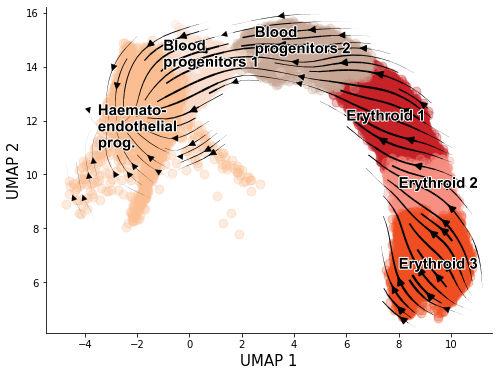

In [115]:
fig, ax = plt.subplots(figsize=(8, 6))
for i in set(color):
    ax.scatter(sd.Xdr.iloc[color==i, 0], sd.Xdr.iloc[color==i,1], c=f'#{i}', s=80, alpha=0.3)
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.5, grid_density=25, radius=0.3, lw_coef=120000, arrowsize=1.5)

ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(-3.5, 11, 'Haemato-\nendothelial \nprog.', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-1, 14, 'Blood \nprogenitors 1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(2.5, 14.5, 'Blood \nprogenitors 2', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(6, 12, 'Erythroid 1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(8, 9.5, 'Erythroid 2', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(8, 6.5, 'Erythroid 3', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
plt.savefig('./buckup/figures/mouse_multistage/blood_transfer_stream.pdf', dpi='figure', format='pdf')

In [27]:
from pseudo_time import calc_phylo_pseudotime

In [31]:
sd = calc_phylo_pseudotime(sd, n_neighbors=80, r_sample=0.05)

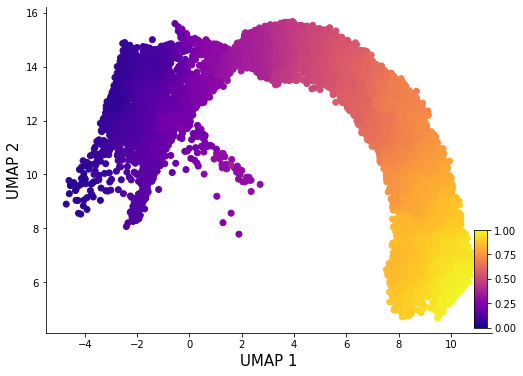

In [116]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:,1], c=sd.phylo_pseudotime, cmap='plasma')
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
plt.savefig('./buckup/figures/mouse_multistage/blood_pseudotime.pdf', dpi='figure', format='pdf')

In [84]:
em_time = meta.loc[xdr.index[cond]].stage.apply(lambda x: float(x[1:])).to_numpy()

In [55]:
from scipy.stats import spearmanr

In [86]:
vio = []
for i in [6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5]:
    vio.append(sd.phylo_pseudotime[em_time==i])

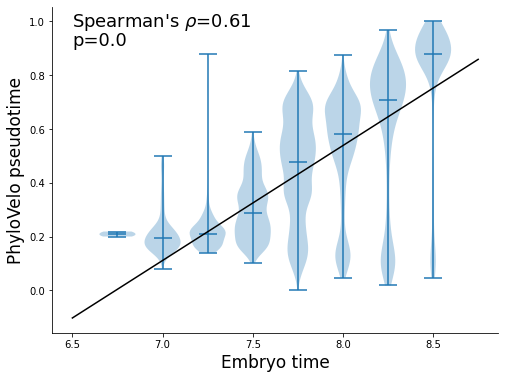

In [117]:
x = em_time
y = sd.phylo_pseudotime
a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(6.5, 8.75 ,60) + b
fig, ax = plt.subplots(figsize=(8,6))
ax.violinplot(vio,positions=[6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5], showmedians=1, widths=0.2)
ax.plot(np.linspace(6.5, 8.75 ,60), y_est, '-', c='k')
ax.set_xlabel('Embryo time', fontsize=17)
ax.set_ylabel('PhyloVelo pseudotime', fontsize=17)
rho, pval = spearmanr(x, y)
ax.text(6.5, 0.98, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=18)
# ax.text(6.5, 0.91, r'$p={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
ax.text(6.5,0.91, r'p={}'.format(pval), fontsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('./buckup/figures/mouse_multistage/blood_pseudotime_cmp.pdf', dpi='figure', format='pdf')